# Normalize and filter

In [1]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.plot as plot
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.4.0


In [2]:
# hard-code the paths of our input and output directories
path_input = "../data/input"
path_output = "../data/output"

# check input images are loaded
stack.check_input_data(path_input)

experiment_1_dapi_fov_1.tif is already in the directory
experiment_1_smfish_fov_1.tif is already in the directory


In this notebook, we show examples of **image normalization** and different **filters**. For some examples we only use a 2D image, taking a centered z-slice.

In [3]:
recipe = {
    "fov": "fov_1",
    "c": ["dapi", "smfish"],
    "opt": "experiment_1",
    "ext": "tif",
    "pattern": "opt_c_fov.ext"}
image = stack.build_stack(recipe, input_folder=path_input) 
print("\r shape: {0}".format(image.shape))
print("\r dtype: {0}".format(image.dtype))

 shape: (1, 2, 23, 650, 500)
 dtype: uint16


In [4]:
nuc_2d = image[0, 0, 11, ...]
rna_2d = image[0, 1, 11, ...]
print("dapi channel (one z-slice)")
print("\r shape: {0}".format(nuc_2d.shape))
print("\r dtype: {0}".format(nuc_2d.dtype))
print("smfish channel (one z-slice)")
print("\r shape: {0}".format(rna_2d.shape))
print("\r dtype: {0}".format(rna_2d.dtype))

dapi channel (one z-slice)
 shape: (650, 500)
 dtype: uint16
smfish channel (one z-slice)
 shape: (650, 500)
 dtype: uint16


## Rescale pixel intensity

**Rescaling an image** means we rescale its pixel intensity range to its dtype limits (or between 0 and 1 for float image). We can **enhance the contrast** of the image by stretching it. The operation is a simple rescaling, but based on a smaller range of pixel intensity than the one actually observed in the image. 

In [5]:
print("smfish")
print("\r min: {0}".format(rna_2d.min()))
print("\r max: {0}".format(rna_2d.max()))
rna_2d_rescaled = stack.rescale(rna_2d, channel_to_stretch=None)
print("smfish rescaled")
print("\r min: {0}".format(rna_2d_rescaled.min()))
print("\r max: {0}".format(rna_2d_rescaled.max()))
rna_2d_stretched = stack.rescale(rna_2d, channel_to_stretch=0)
print("smfish stretched")
print("\r min: {0}".format(rna_2d_stretched.min()))
print("\r max: {0}".format(rna_2d_stretched.max()))

smfish
 min: 3867
 max: 42327
smfish rescaled
 min: 0
 max: 65535
smfish stretched
 min: 0
 max: 65535


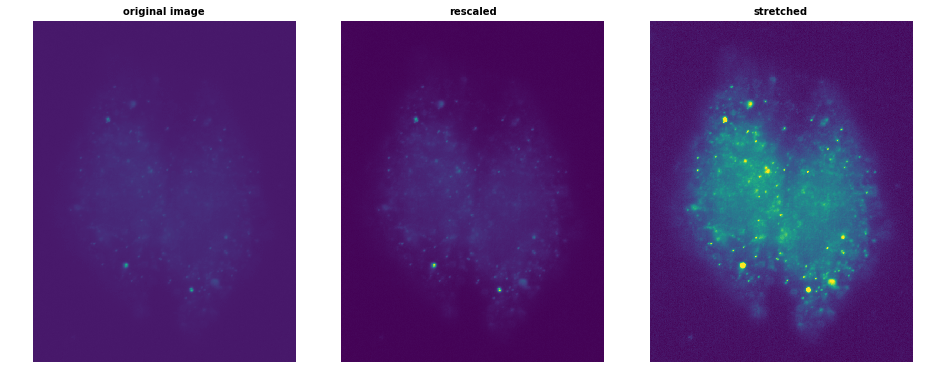

In [6]:
images = [rna_2d, rna_2d_rescaled, rna_2d_stretched]
titles = ["original image", "rescaled", "stretched"]
plot.plot_images(images, titles=titles, framesize=(13, 6))

Rescaling or stretching an image is directly possible through the plotting functions, without transforming the original image.

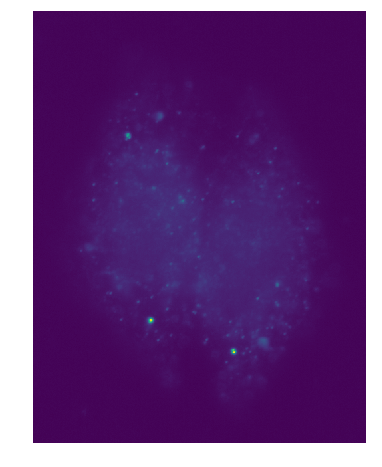

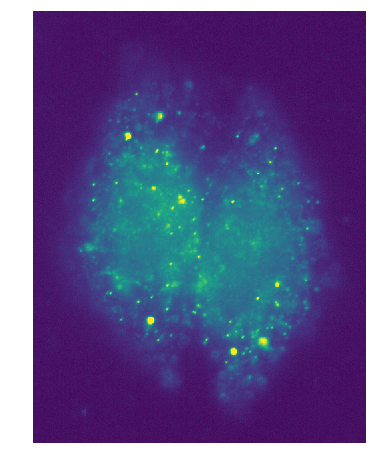

In [7]:
plot.plot_images(rna_2d, framesize=(13, 6), rescale=True)
plot.plot_images(rna_2d, framesize=(13, 6), contrast=True)

## Cast images

To properly **cast an image**, we follow the convention of scikit image. We rescale the image values within the appropriate range. In particular, when we cast an unsigned integer in float, we rescale it between 0 and 1.

In [8]:
# 8-bit
image_8bit = stack.cast_img_uint8(image, catch_warning=True)
print("dtype: {0}".format(image_8bit.dtype))
print("\r min: {0}".format(image_8bit.min()))
print("\r max: {0}".format(image_8bit.max()))

# 16-bit
print("dtype: {0}".format(image.dtype))
print("\r min: {0}".format(image.min()))
print("\r max: {0}".format(image.max()))

# 32-bit
image_32bit = stack.cast_img_float32(image)
print("dtype: {0}".format(image_32bit.dtype))
print("\r min: {0}".format(image_32bit.min()))
print("\r max: {0}".format(image_32bit.max()))

# 64-bit
image_64bit = stack.cast_img_float64(image)
print("dtype: {0}".format(image_64bit.dtype))
print("\r min: {0}".format(image_64bit.min()))
print("\r max: {0}".format(image_64bit.max()))

dtype: uint8
 min: 4
 max: 188
dtype: uint16
 min: 1025
 max: 48212
dtype: float32
 min: 0.0156404972076416
 max: 0.7356679439544678
dtype: float64
 min: 0.015640497444113832
 max: 0.7356679636835279


## Filter images

Several **basic filters** are only available for 2D images. Different kernel sizes and shapes can be applied: *square*, *disk*, *diamond* or *rectangle*.

In [9]:
nuc_2d_mean = stack.mean_filter(nuc_2d, kernel_shape="square", kernel_size=30)
nuc_2d_median = stack.median_filter(nuc_2d, kernel_shape="square", kernel_size=30)
nuc_2d_min = stack.minimum_filter(nuc_2d, kernel_shape="square", kernel_size=30)
nuc_2d_max = stack.maximum_filter(nuc_2d, kernel_shape="square", kernel_size=30)

/Users/arthur/miniconda3/envs/bigfish/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 15 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


A **gaussian filter** can be applied to a 2D or 3D image. The `sigma` parameter sets the standard deviation for the gaussian kernel. Larger is the sigma, larger will be the kernel.

In [10]:
nuc_2d_gaussian = stack.gaussian_filter(nuc_2d, sigma=5)

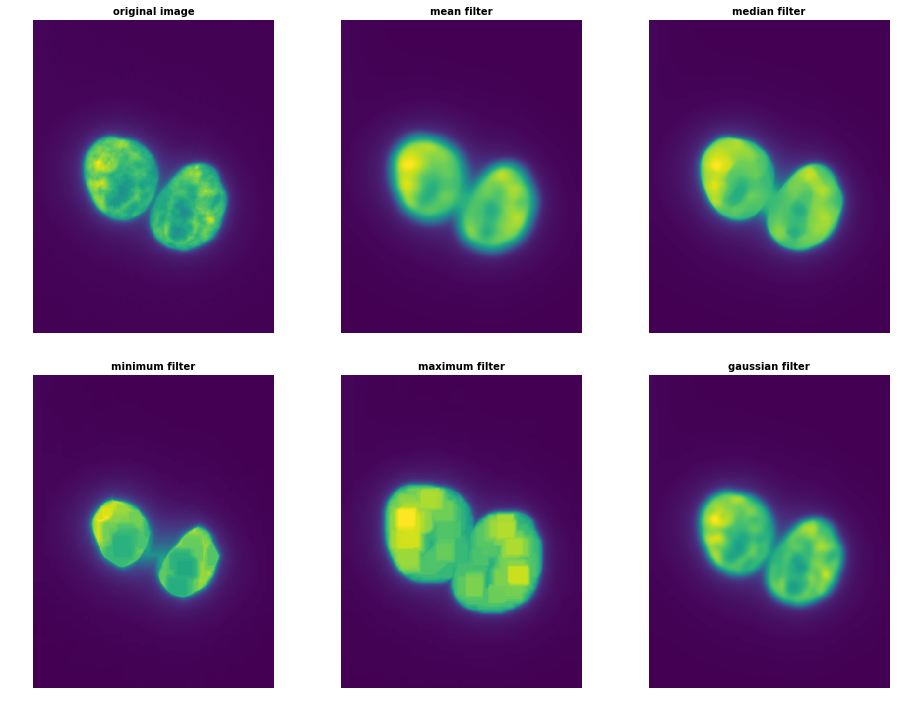

In [11]:
images = [nuc_2d, nuc_2d_mean, nuc_2d_median, nuc_2d_min, nuc_2d_max, nuc_2d_gaussian]
titles = ["original image", "mean filter", "median filter", "minimum filter", "maximum filter", "gaussian filter"]
plot.plot_images(images, rescale=True, titles=titles, framesize=(13, 10))

Up to a certain image size, `bigfish.stack.dilation_filter` and `bigfish.stack.erosion_filter` algorithms are faster implementations than `bigfish.stack.maximum_filter` and `bigfish.stack.minimum_filter`, for the same results. It is even optimized for binary images. Those filters should be used with a 2D image.

In [12]:
# we threshold a slice of the dapi channel to transform a binary image
nuc_bool = nuc_2d > 22000
nuc_dilated = stack.dilation_filter(nuc_bool, kernel_shape="square", kernel_size=30)
nuc_eroded = stack.erosion_filter(nuc_bool, kernel_shape="square", kernel_size=30)

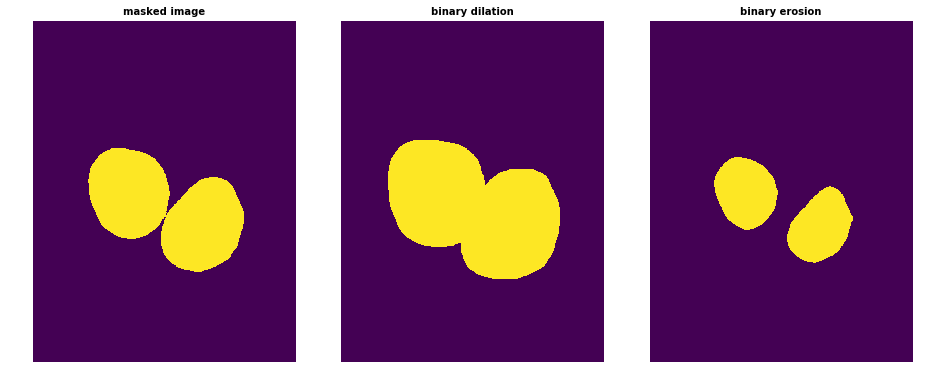

In [13]:
images = [nuc_bool, nuc_dilated, nuc_eroded]
titles = ["masked image", "binary dilation", "binary erosion"]
plot.plot_images(images, rescale=True, titles=titles, framesize=(13, 6))

Filters can be applied to **denoise an image**:
- `bigfish.stack.log_filter` applies a gaussian filter (to smooth the image and remove the high frequency noise) followed by a laplacian filter (to find areas of rapid change). This filter can be used to enhance the signal-to-noise ratio of the spots before detecting them. It is available for 2D and 3D images.
- `bigfish.stack.remove_background_mean` approximates the background of the image (the low frequency noise) by a large mean filter and substracts it from the original image. It is only available for 2D images.
- `bigfish.stack.remove_background_gaussian` approximates the background of the image (the low frequency noise) by a large gaussian filter and substracts it from the original image. It is available for 2D and 3D images.

In [14]:
rna_log = stack.log_filter(rna_2d, sigma=3)
rna_background_mean = stack.remove_background_mean(rna_2d, kernel_shape="disk", kernel_size=200)
rna_background_gaussian = stack.remove_background_gaussian(rna_2d, sigma=3)

/Users/arthur/miniconda3/envs/bigfish/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 15 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


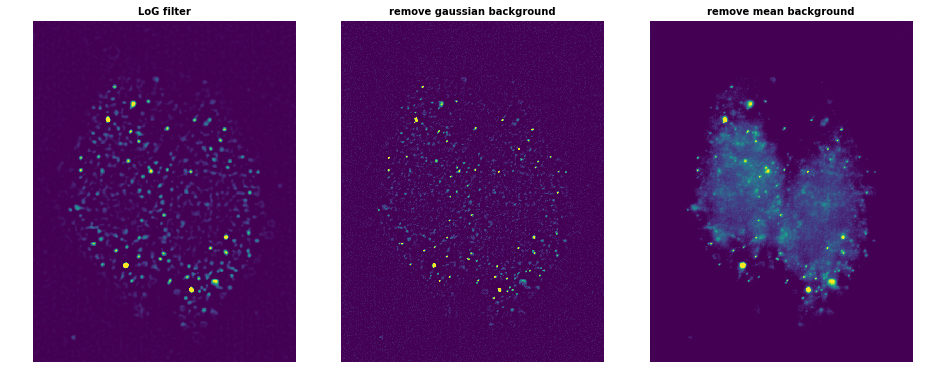

In [15]:
images = [rna_log, rna_background_gaussian, rna_background_mean]
titles = ["LoG filter", "remove gaussian background", "remove mean background"]
plot.plot_images(images, contrast=True, titles=titles, framesize=(13, 6))